In [1]:
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import random
import monai
from os import makedirs
from os.path import join, basename
from tqdm import tqdm
from copy import deepcopy
from time import time
import numpy as np
import torch
import yaml
import cv2
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from transformers import CLIPTokenizer, CLIPTextModel
import argparse
from torch.nn.parallel import DataParallel
import json
from modules import DiscreteGroupImageCanonicalization, ESCNNEquivariantNetwork
from modules import TextPromptEncoder, MedSAMWithCanonicalization
from modules import sam_model_registry
from utils import FLanSDataset_pos_only, normalized_surface_distance_np, test_epoch_batch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")

# print("All warnings are suppressed!")
seed = 0
torch.cuda.empty_cache()
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True  # To ensure deterministic behavior for certain operations
torch.backends.cudnn.benchmark = False  # Turn off optimization that may introduce randomness

### 1. Load MedSAM

In [3]:
medsam_model = sam_model_registry["vit_b"](checkpoint="preload/sam_vit_b_01ec64.pth")
medsam_model = medsam_model.to(device)
medsam_model.eval()

def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

### 2. Load SAM2

In [4]:
# sys.path.append("/home/ec2-user/SageMaker/SegmentAsYouWish/text_prompt/evals/segmentanything2")
# os.chdir("/home/ec2-user/SageMaker/SegmentAsYouWish/text_prompt/evals/segmentanything2")
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [5]:
checkpoint = "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

### 3. Load FLanS

In [6]:
os.chdir("/home/ec2-user/SageMaker/SegmentAsYouWish/text_prompt")
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Load labels
with open("prompts/free_form_text_prompts.json", 'r') as file:
    label_dict = json.load(file)

with open("configs/test_data_paths.json", 'r') as file:
    test_data_path_lists = json.load(file)
    
with open("prompts/positional_free_form_text_prompts.json", 'r') as file:
    pos_prompt_dict = json.load(file)

with open("prompts/organ_positions.json", 'r') as file:
    pos_file_dict = json.load(file)
    
with open("prompts/organ_bounding_boxes.json", 'r') as file:
    pos_box_dict = json.load(file)
config_yaml = load_config("configs/train_config_main1.yaml")
checkpoint_name = "82_checkpoint_cosine_two_stage_canonTrue_augTrue_classify_headFalse_freezeimagencoderFalse_lr_prompt0.0001_lr_imgenc0.0001_lr_imgdec0.0001_lr_can0.0001_lr_class0.0001_bz2_poolingmean_gradstraight_through_canparams9_8_3_8.pth"
work_dir = config_yaml["data"]["work_dir"]
num_epochs = config_yaml["hyperparameter"]["max_epochs"]
batch_size = config_yaml["hyperparameter"]["batch_size"]
num_workers = config_yaml["hyperparameter"]["num_workers"]
medsam_checkpoint = config_yaml["model"]["medsam_checkpoint"]
data_aug = config_yaml["train"]["data_aug"]
seed = config_yaml["hyperparameter"]["seed"]
augmented_textlabel = config_yaml["train"]["textlabel_aug"]
use_canonicalization = config_yaml["train"]["use_canonicalization"]
freeze_image_encoder = config_yaml["train"]["freeze_image_encoder"]
use_classify_head = config_yaml["train"]["classify_head"]
text_pooling = config_yaml["hyperparameter"]["text_pooling"]

print("Test Datasets:", test_data_path_lists.keys())

with torch.no_grad():
    ###### Initialize Text Prompt Encoder ###### 
    text_prompt_encoder = TextPromptEncoder(
        embed_dim=config_yaml["model"]["text_embed_dim"],
        image_embedding_size=(64, 64),
        input_image_size = (config_yaml["data"]["image_size"], config_yaml["data"]["image_size"]),
        mask_in_chans=1,
        activation=nn.GELU,
    )

    sam_model = sam_model_registry["vit_b"](checkpoint=medsam_checkpoint)
    medsam_prompt_encoder_state_dict = sam_model.prompt_encoder.state_dict()
    ## Load pretrained weights from MedSAM's prompt encoder except for the text encoder
    for keys in text_prompt_encoder.state_dict().keys():
        if keys in medsam_prompt_encoder_state_dict.keys():
            text_prompt_encoder.state_dict()[keys] = deepcopy(medsam_prompt_encoder_state_dict[keys])
        else:
            assert keys.startswith("text_encoder")

    ###### Initialize Canonicalization Network ###### 
    class CanonicalizationHyperparams:
        def __init__(self):
            self.network_type = "escnn" # group equivariant canonicalization
            self.resize_shape = config_yaml["canonicalization"]["resize_shape"] # resize shape for the canonicalization network
            self.network_hyperparams = {
                "kernel_size": config_yaml["canonicalization"]["kernel_size"], # Kernel size for the canonization network
                "hidden_dim": config_yaml["canonicalization"]["hidden_dim"],
                "out_channels": config_yaml["canonicalization"]["out_channels"], # Number of output channels for the canonization network
                "num_layers": config_yaml["canonicalization"]["num_layers"], # Number of layers in the canonization network
                "group_type": config_yaml["canonicalization"]["group_type"],#"roto-reflection", #rotation", # Type of group for the canonization network
                "group_order": config_yaml["canonicalization"]["group_order"], # Number of rotations for the canonization network 
            }
            self.beta = config_yaml["canonicalization"]["beta"]
            self.input_crop_ratio = config_yaml["canonicalization"]["input_crop_ratio"]
            self.gradient_trick = config_yaml["canonicalization"]["gradient_trick"] #"gumbel_softmax" / "straight_through"
    canonicalization_hyperparams = CanonicalizationHyperparams()

    # initialize the can network: 
    image_shape = (config_yaml["data"]["inp_channels"], config_yaml["data"]["image_size"], config_yaml["data"]["image_size"])
    canonicalization_def = ESCNNEquivariantNetwork(
        inp_channels = config_yaml["data"]["inp_channels"], 
        **canonicalization_hyperparams.network_hyperparams
    )#.to(device)
    canonicalization_network = DiscreteGroupImageCanonicalization(canonicalization_def, canonicalization_hyperparams, image_shape)#.to(device)


    ###### Initialize the Main Model ###### 
    # need to adjsut the freeze option here: # todo
    flans_model = MedSAMWithCanonicalization(
        image_encoder=sam_model.image_encoder,
        mask_decoder=deepcopy(sam_model.mask_decoder),
        prompt_encoder=text_prompt_encoder,
        canonicalization_network = canonicalization_network, 
        use_canonicalization = use_canonicalization,
        use_classify_head = use_classify_head,
        freeze_image_encoder=freeze_image_encoder # False
    ).to(device)

    checkpoint = torch.load("results/foundation_model/" + checkpoint_name)
    flans_model.load_state_dict(checkpoint["model"], strict = False)

Test Datasets: dict_keys(['FLARE22_test', 'WORD_test', 'RAOS'])


### 4. Dataset

In [9]:
test_dataset = FLanSDataset_pos_only(data_path_lists = test_data_path_lists,
                                     label_dict = label_dict, 
                                      pos_file_dict = pos_file_dict, 
                                      pos_prompt_dict = pos_prompt_dict,
                                      pos_box_dict = pos_box_dict)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4)

In [10]:
for batch in test_loader:
    image, gt2D, tokens, text, box = batch["image"].to(device), batch["gt2D"].to(device), batch["token"].to(device),  batch["text"], batch['box']
    break

In [19]:
idx = 3

# SAM2 predictions
with torch.no_grad():
    image_np = image[idx].permute(1,2,0).cpu().data.numpy()
    predictor.set_image(image_np)
    points = box[idx].cpu().data.numpy()
    sam2_pred = predictor.predict(point_coords=None, point_labels=None,box=points[None, :], multimask_output=False)[0][0]
    
# MedSAM predictions
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(image[idx:idx+1])
    medsam_pred = medsam_inference(medsam_model, image_embedding, box[idx:idx+1].to(device), H = 256, W = 256)
    medsam_pred = cv2.resize(medsam_pred, (1024, 1024), interpolation=cv2.INTER_LINEAR)
    
# FLanS predictions
with torch.no_grad():
    # remember to remove canonicalization
    flans_model.use_canonicalization = False
    flans_pred, _ = flans_model(image[idx:idx+1], tokens[idx:idx+1])
    flans_pred = (torch.sigmoid(flans_pred) > 0.5).float().cpu().data.numpy()[0,0]
    flans_pred = cv2.resize(flans_pred, (1024, 1024), interpolation=cv2.INTER_LINEAR)
target = cv2.resize(gt2D[idx][0].float().cpu().data.numpy(), (1024, 1024), interpolation=cv2.INTER_LINEAR)

I need to segment the largest structure visible in this image.


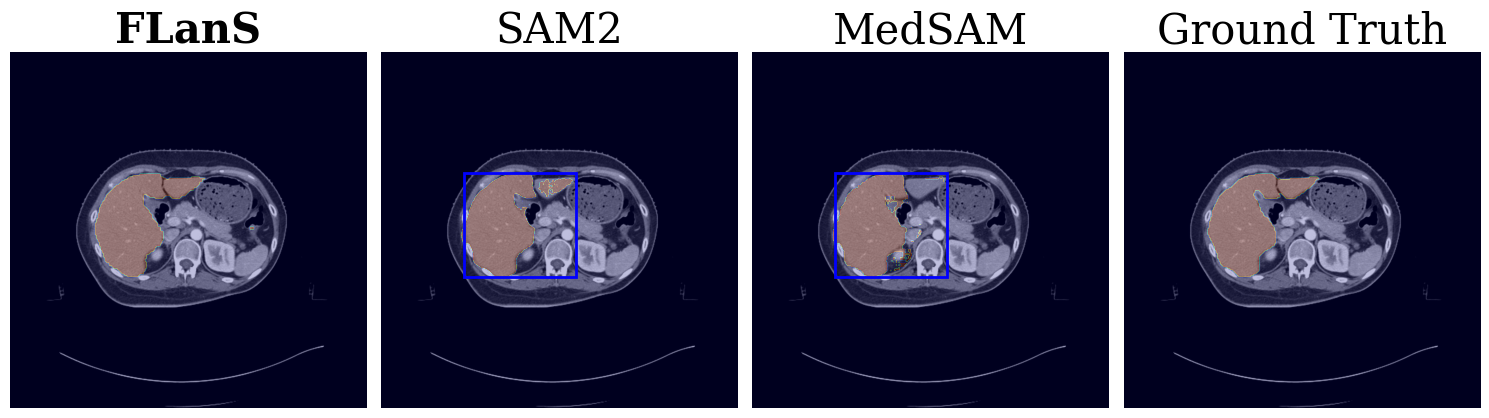

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))#, gridspec_kw={'width_ratios': [2, 4, 4, 4, 4]}) # Add an extra axis for text, 
alpha = 0.25
cmap = 'jet'

# Text content for the leftmost text box
text_content = text[0][idx]
print(text_content)

# Plot something in each subplot
axes[0].imshow(image_np)
axes[0].imshow(flans_pred, cmap=cmap, alpha=alpha)  
axes[0].set_title('FLanS', size=30, fontdict={'family': 'serif', 'weight': 'bold'})
axes[0].axis('off')

axes[1].imshow(image_np)
axes[1].imshow(sam2_pred, cmap=cmap, alpha=alpha)  
x_min, y_min, x_max, y_max = box[idx]  # Swapped the order
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=2, edgecolor='b', facecolor='none')
axes[1].add_patch(rect)
axes[1].set_title('SAM2', size=30, fontdict={'family': 'serif'})
axes[1].axis('off')

axes[2].imshow(image_np)
axes[2].imshow(medsam_pred, cmap=cmap, alpha=alpha)  
x_min, y_min, x_max, y_max = box[idx]  # Swapped the order
rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                         linewidth=2, edgecolor='b', facecolor='none')
axes[2].add_patch(rect)
axes[2].set_title('MedSAM', size=30, fontdict={'family': 'serif'})
axes[2].axis('off')

axes[3].imshow(image_np)
axes[3].imshow(target, cmap=cmap, alpha=alpha)  
axes[3].set_title('Ground Truth', size=30, fontdict={'family': 'serif'})
axes[3].axis('off')

plt.tight_layout()
plt.savefig('agnostic1_'+str(idx)+'.png', dpi=200, bbox_inches='tight')  # Saving
plt.show()